In [1]:
from cil.utilities import dataexample, noise
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import zarr
import pandas as pd
from skimage.metrics import peak_signal_noise_ratio as PSNR
from skimage.metrics import structural_similarity as SSIM

from matplotlib.lines import Line2D

# Get colors / markers / functions
colors = ("b", "g", "r", "c", "m", "y", "k")
markers = []
for m in Line2D.markers:
    try:
        if len(m) == 1 and m != " ":
            markers.append(m)
    except TypeError:
        pass

plt.rcParams['lines.linewidth'] = 5
plt.rcParams['lines.markersize'] = 20
plt.rcParams['font.size'] = 30

def pad_subarr_nan(list_of_arrays):
    max_len = max(arr.shape[0] for arr in list_of_arrays)
    padded_list = [np.pad(arr, (0, max_len - arr.shape[0]), constant_values=np.nan) for arr in list_of_arrays]
    return padded_list

### Load Data and noisy/blurry

In [10]:
data = zarr.load("../data/denoising/noisy_shapes_seed_10_var_0.05.zarr")["gtruth"]
noisy = zarr.load("results/noisy_blurry_shapes_var_0.001_seed_10.zarr")

alpha = 0.025
tv_deblurring = zarr.load("results/fista_optimal_shapes_tv_alpha_{}_warm_500.zarr".format(alpha))
tv_deblurring_objective = tv_deblurring["objective"]
tv_deblurring_solution = tv_deblurring["solution"]

### Show data

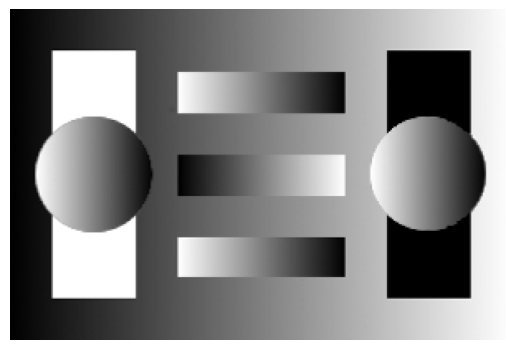

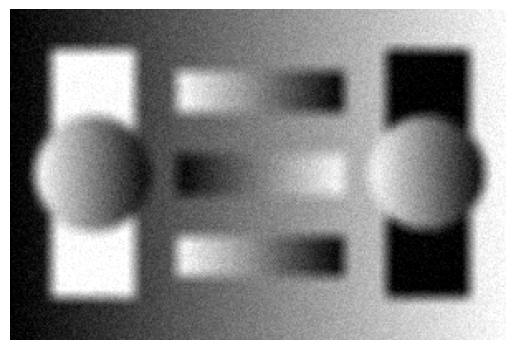

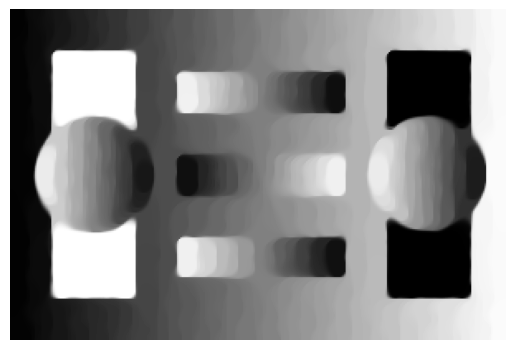

In [11]:
plt.figure()
plt.imshow(data, cmap="gray")
plt.axis("off")
# plt.savefig("figures/deblurring/gtruth_shapes.png", bbox_inches="tight")
plt.show()

plt.figure()
plt.imshow(noisy["blurred_noisy"], cmap="gray")
plt.axis("off")
# plt.savefig("figures/deblurring/noisy_blurry.png", bbox_inches="tight")
plt.show()

plt.figure()
plt.imshow(tv_deblurring_solution, cmap="gray")
plt.axis("off")
# plt.savefig("figures/deblurring/tv_denoised.png", bbox_inches="tight")
plt.show()

### Load meta from ProxSkip and FISTA

In [18]:
# gather data for warm, prob and algos

probs = [0.05, 0.1, 0.2, 0.5, 1.0]
warm_num = [10, 50, 100]

tmp_fista_time = {i:[] for i in warm_num}
tmp_proxskip_time = {i:{j:[] for j in probs} for i in warm_num}

tmp_fista_rse = {i:[] for i in warm_num}
tmp_proxskip_rse = {i:{j:[] for j in probs} for i in warm_num}

tmp_proxskip_use_prox = {i:{j:None for j in probs} for i in warm_num}

max_iterations = 3000
num_runs = 10

for warm in warm_num:

    for run in range(num_runs):
        
        res_fista = zarr.load("results/deblurring_runs_alpha_{}/fista_run_{}_warm_{}.zarr".format(alpha,run, warm))
        # res_fista = zarr.load("results_deblurring/deblurring_runs_alpha_{}/fista_run_{}_warm_{}_with_pdhg_precond_optimal.zarr".format(alpha,run, warm))                              
        tmp_fista_time[warm].append(res_fista["timing"])
        tmp_fista_rse[warm].append(res_fista["rse"])

for warm in warm_num:

    for prob in probs:

        for run in range(num_runs): 
            
            # res_proxskip = zarr.load("results_deblurring/deblurring_runs_alpha_{}/proxskip_run_{}_warm_{}_prob_{}.zarr".format(alpha, run, warm, prob))
            res_proxskip = zarr.load("results/deblurring_runs_alpha_{}/proxskip_run_{}_warm_{}_prob_{}_with_pdhg_precond_optimal.zarr".format(alpha, run, warm, prob))
            tmp_proxskip_time[warm][prob].append(res_proxskip["timing"]) 
            tmp_proxskip_rse[warm][prob].append(res_proxskip["rse"])
            tmp_proxskip_use_prox[warm][prob] = res_proxskip["use_prox"].item()


### Compute the average time per iteration

In some runs there is an offset of 1 iteration. Pad with np.nan.


In [19]:
for warm in warm_num:
    tmp_fista_time[warm] = pad_subarr_nan(tmp_fista_time[warm])
    tmp_fista_rse[warm] = pad_subarr_nan(tmp_fista_rse[warm])
    for prob in probs:
        tmp_proxskip_time[warm][prob] = pad_subarr_nan(tmp_proxskip_time[warm][prob])
        tmp_proxskip_rse[warm][prob] = pad_subarr_nan(tmp_proxskip_rse[warm][prob])
        

In [20]:
fista_avg_time_per_iteration = {i:None for i in warm_num}
proxskip_avg_time_per_iteration = {i:{j:None for j in probs} for i in warm_num}

fista_std_time_per_iteration = {i:None for i in warm_num}
proxskip_std_time_per_iteration = {i:{j:None for j in probs} for i in warm_num}

for warm in warm_num:
    fista_avg_time_per_iteration[warm] = np.nanmean(tmp_fista_time[warm], axis=0)
    fista_std_time_per_iteration[warm] = np.nanstd(tmp_fista_time[warm], axis=0)

    for prob in probs:
        proxskip_avg_time_per_iteration[warm][prob] = np.nanmean(tmp_proxskip_time[warm][prob], axis=0)
        proxskip_std_time_per_iteration[warm][prob] = np.nanstd(tmp_proxskip_time[warm][prob], axis=0)

### Compute time per run

In [21]:
fista_time_per_run = {i:None for i in warm_num}
proxskip_time_per_run = {i:{j:None for j in probs} for i in warm_num}

for warm in warm_num:
    fista_time_per_run[warm] = np.nansum(tmp_fista_time[warm], axis=1)

    for prob in probs:
        proxskip_time_per_run[warm][prob] = np.nansum(tmp_proxskip_time[warm][prob], axis=1)

### Compute average rse per iteration

In [22]:
fista_avg_rse_per_iteration = {i:None for i in warm_num}
proxskip_avg_rse_per_iteration = {i:{j:None for j in probs} for i in warm_num}

fista_std_rse_per_iteration = {i:None for i in warm_num}
proxskip_std_rse_per_iteration = {i:{j:None for j in probs} for i in warm_num}

for warm in warm_num:
    fista_avg_rse_per_iteration[warm] = np.nanmean(tmp_fista_rse[warm], axis=0)
    fista_std_rse_per_iteration[warm] = np.nanstd(tmp_fista_rse[warm], axis=0)

    for prob in probs:
        proxskip_avg_rse_per_iteration[warm][prob] = np.nanmean(tmp_proxskip_rse[warm][prob], axis=0)
        proxskip_std_rse_per_iteration[warm][prob] = np.nanstd(tmp_proxskip_rse[warm][prob], axis=0)

In [23]:

colors = ['steelblue', 'red', 'orange', 'brown', 'green']
markevery = 100
                 

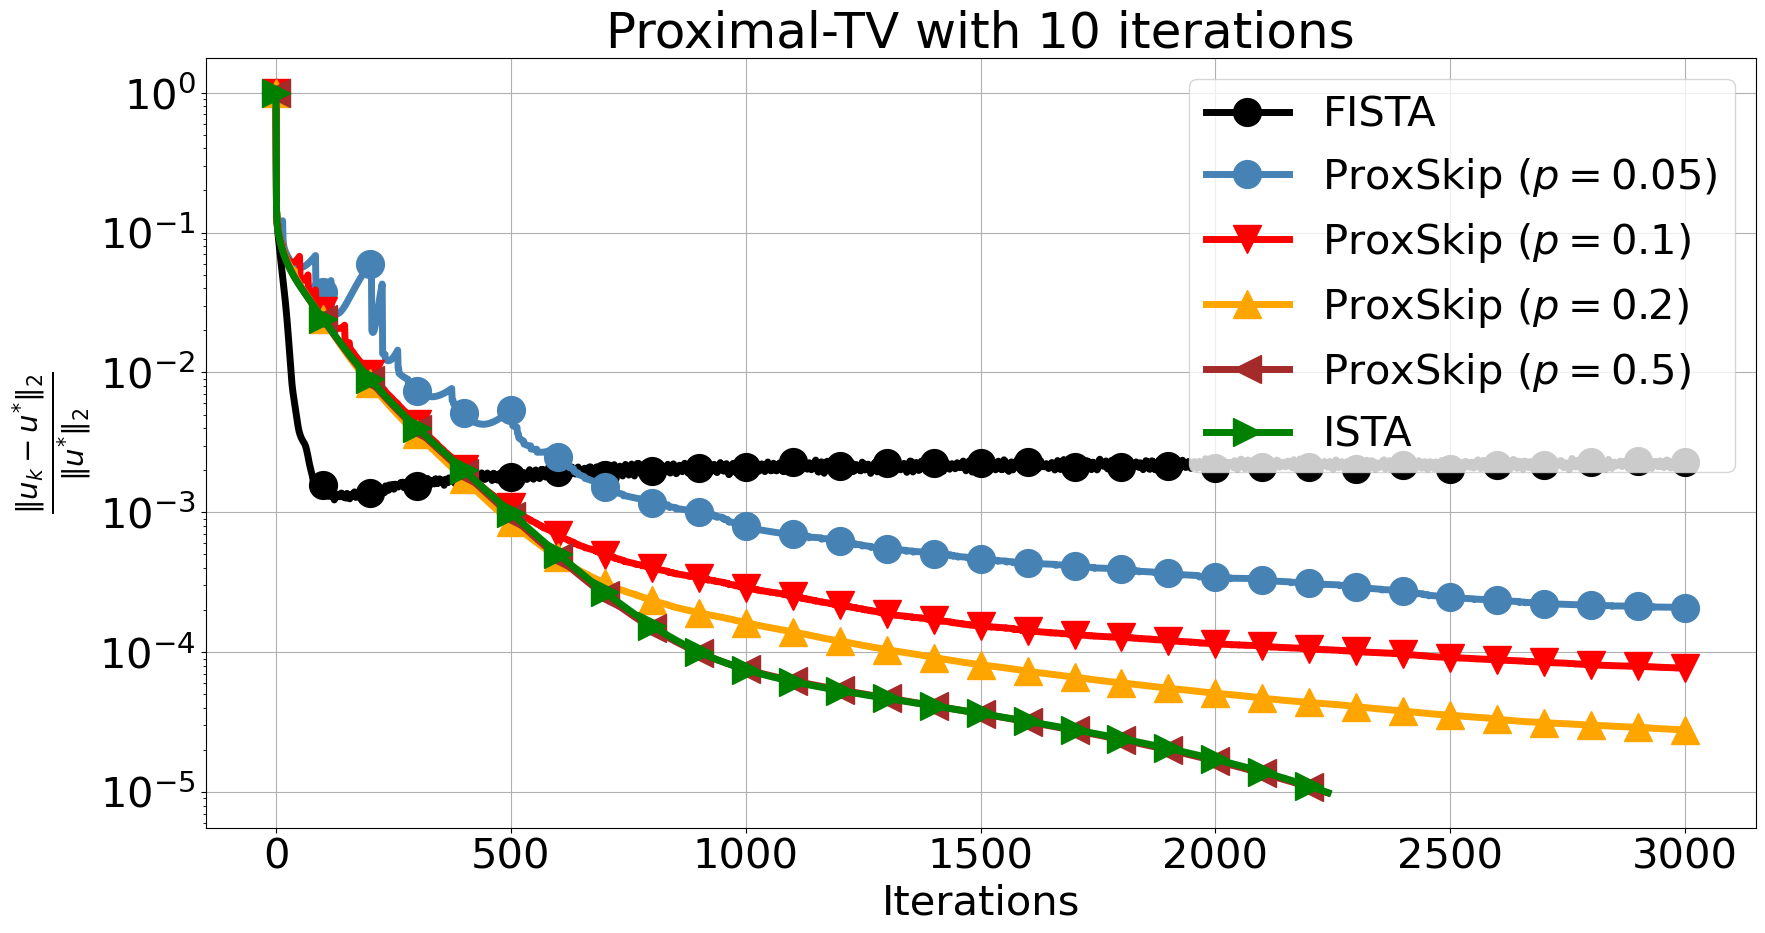

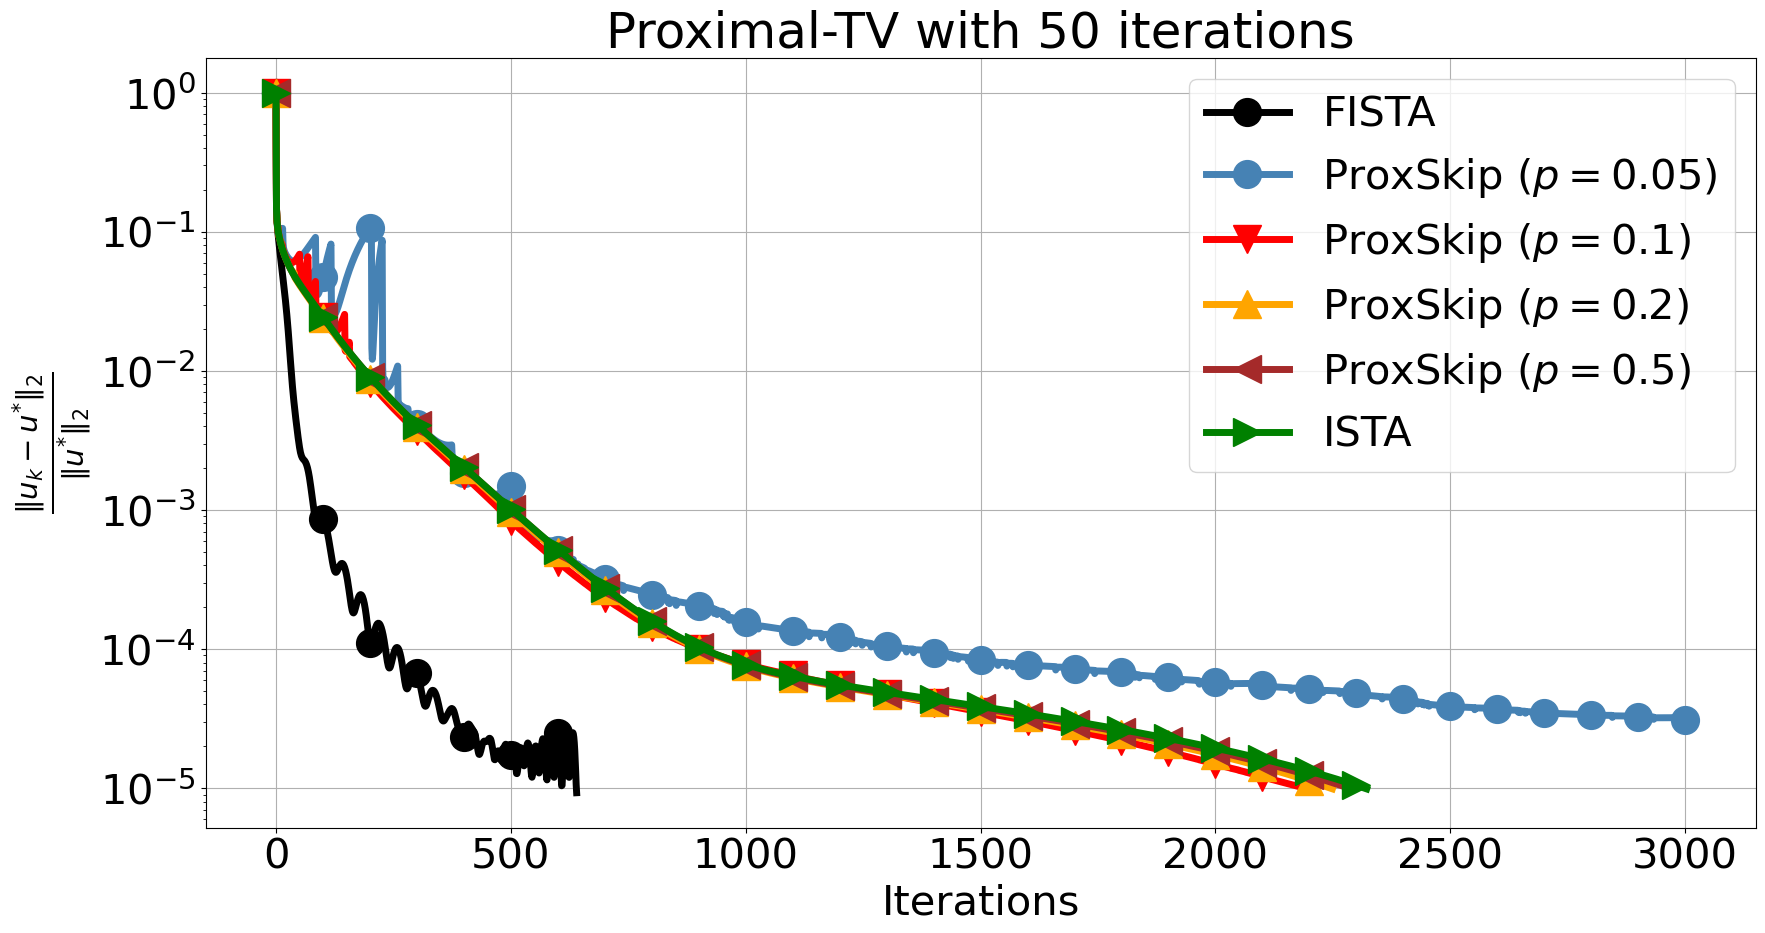

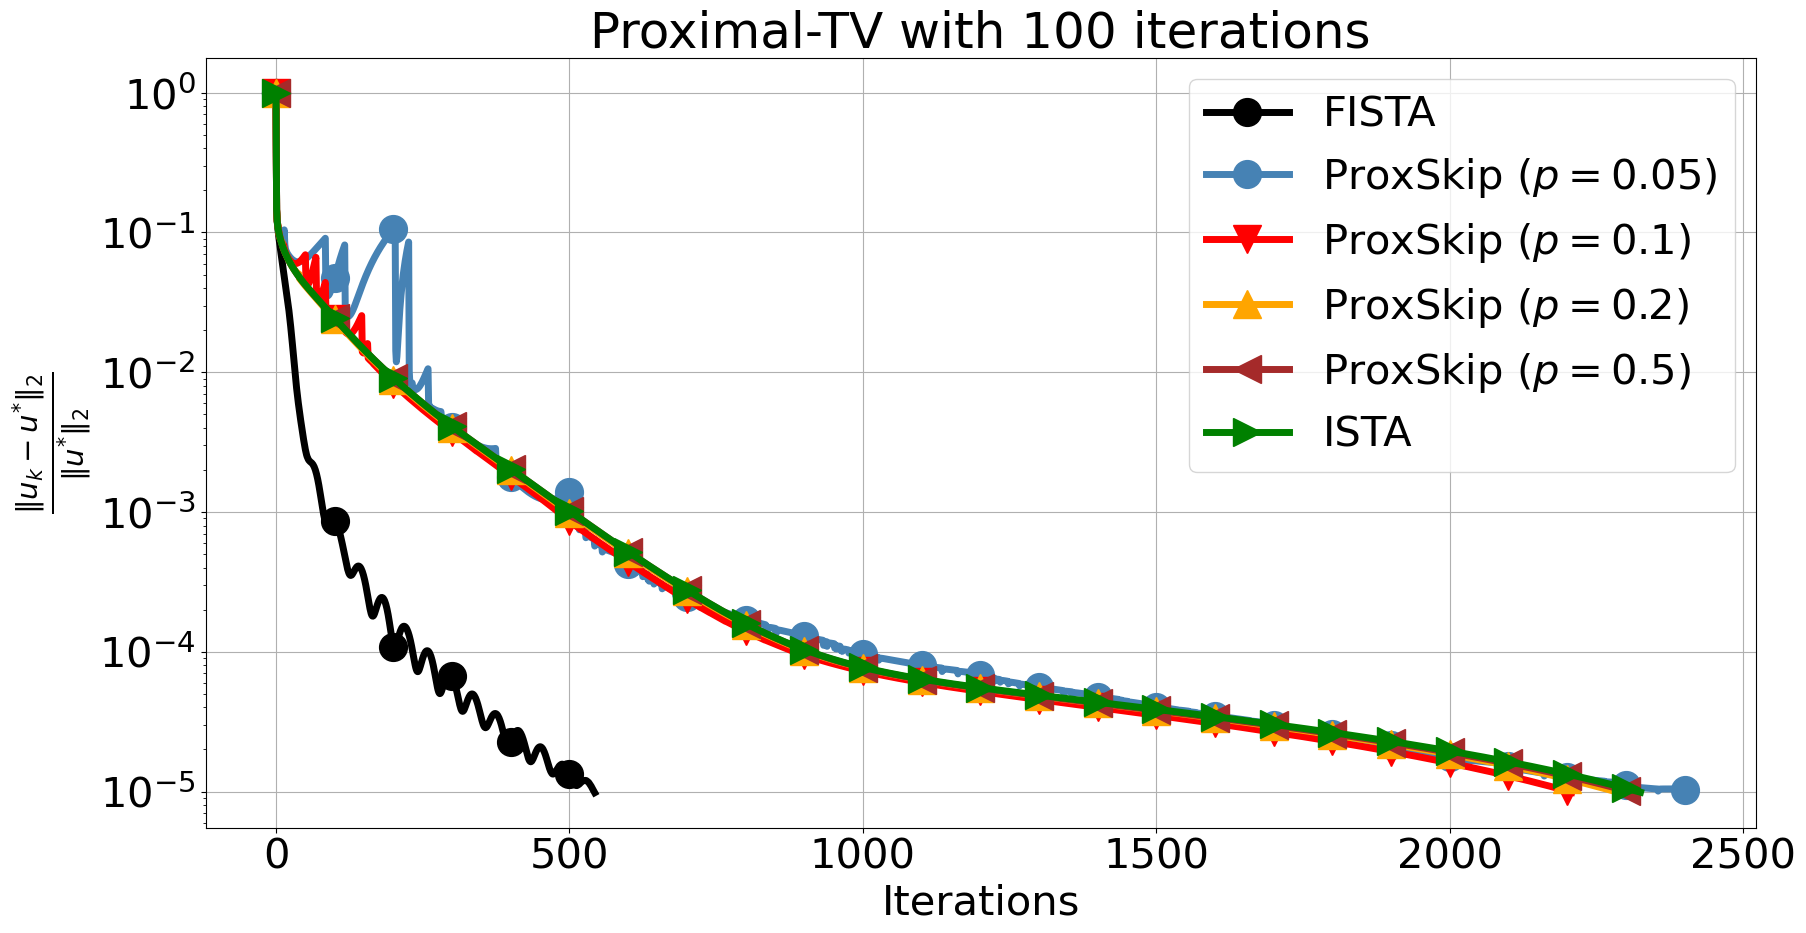

In [24]:
for warm in warm_num:

    fig, ax = plt.subplots(figsize=(20,10))
    
    ax.semilogy(fista_avg_rse_per_iteration[warm], label="FISTA", markevery=markevery, marker=markers[2], color="black")
    for i in range(len(probs)):
        if probs[i]==1.0:
            ax.semilogy(proxskip_avg_rse_per_iteration[warm][probs[i]], label=r"ISTA".format(probs[i]),  
                markevery=markevery, color=colors[i], marker = markers[i+2])
        else:
            ax.semilogy(proxskip_avg_rse_per_iteration[warm][probs[i]], label=r"ProxSkip ($p={}$)".format(probs[i]),  
                        markevery=markevery, color=colors[i], marker = markers[i+2])
    ax.legend()
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel("Iterations")
    plt.title("Proximal-TV with {} iterations".format(warm))
    # plt.savefig("figures/deblurring/ista_fista_proxskip_{}warm_alpha_{}_iterates_xaxis_iterations_pdhg_precond.png".format(warm, alpha), bbox_inches='tight')
    plt.show()

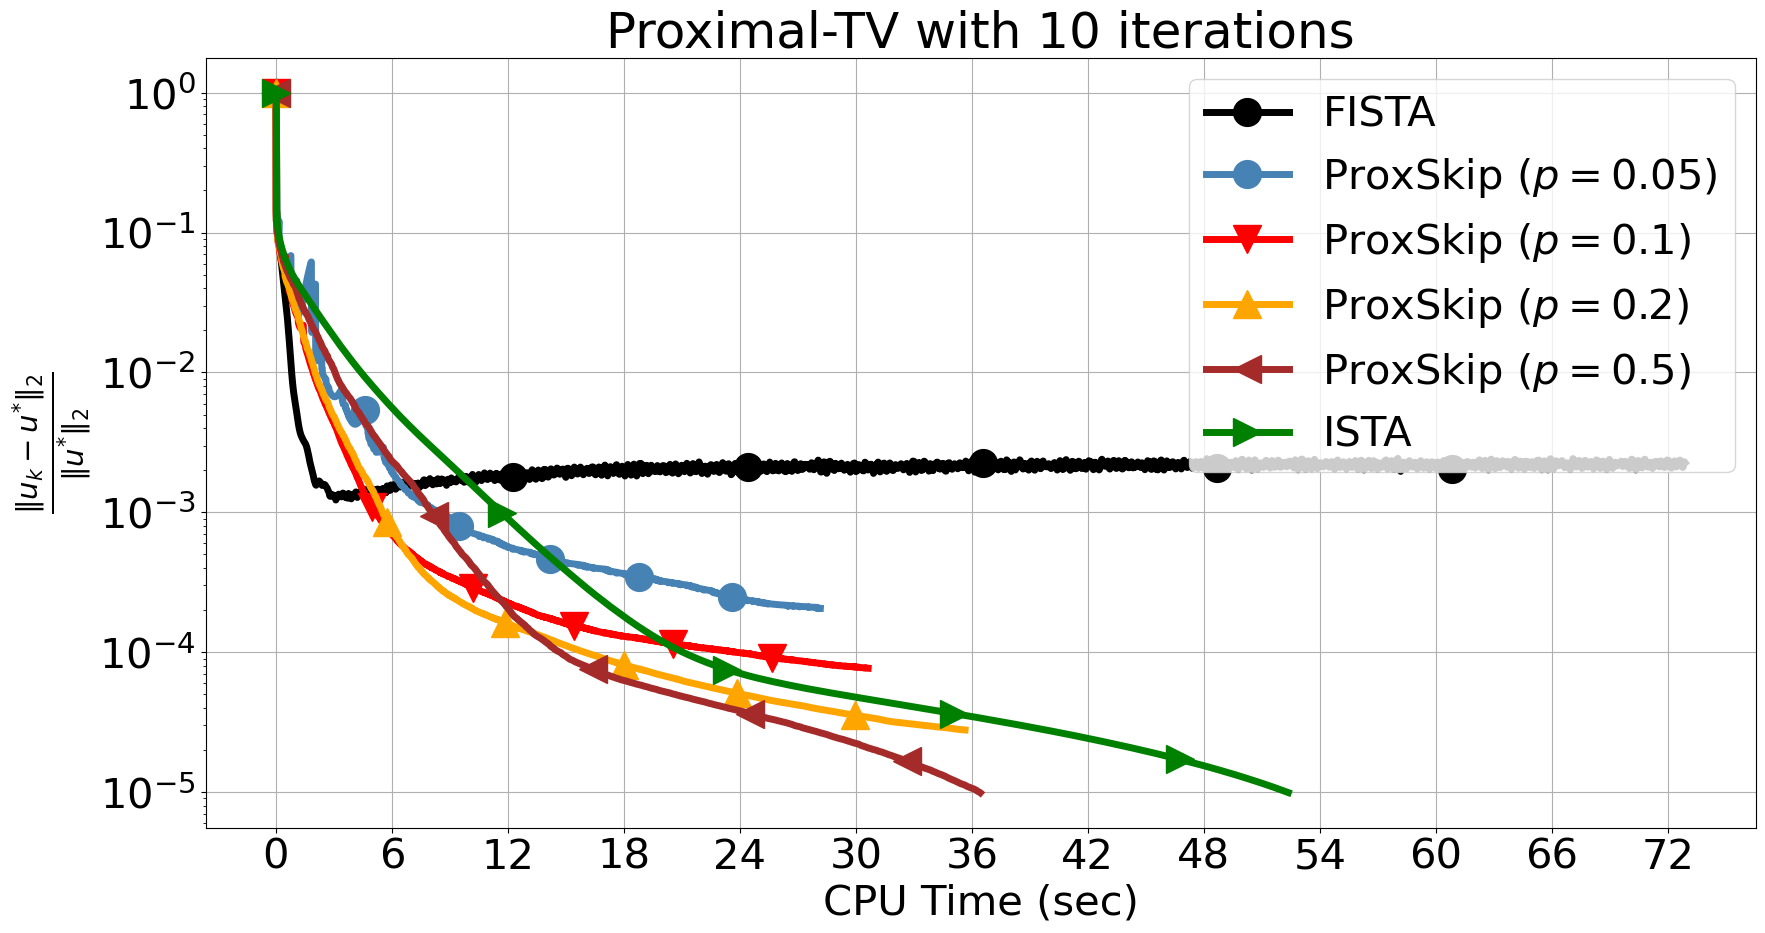

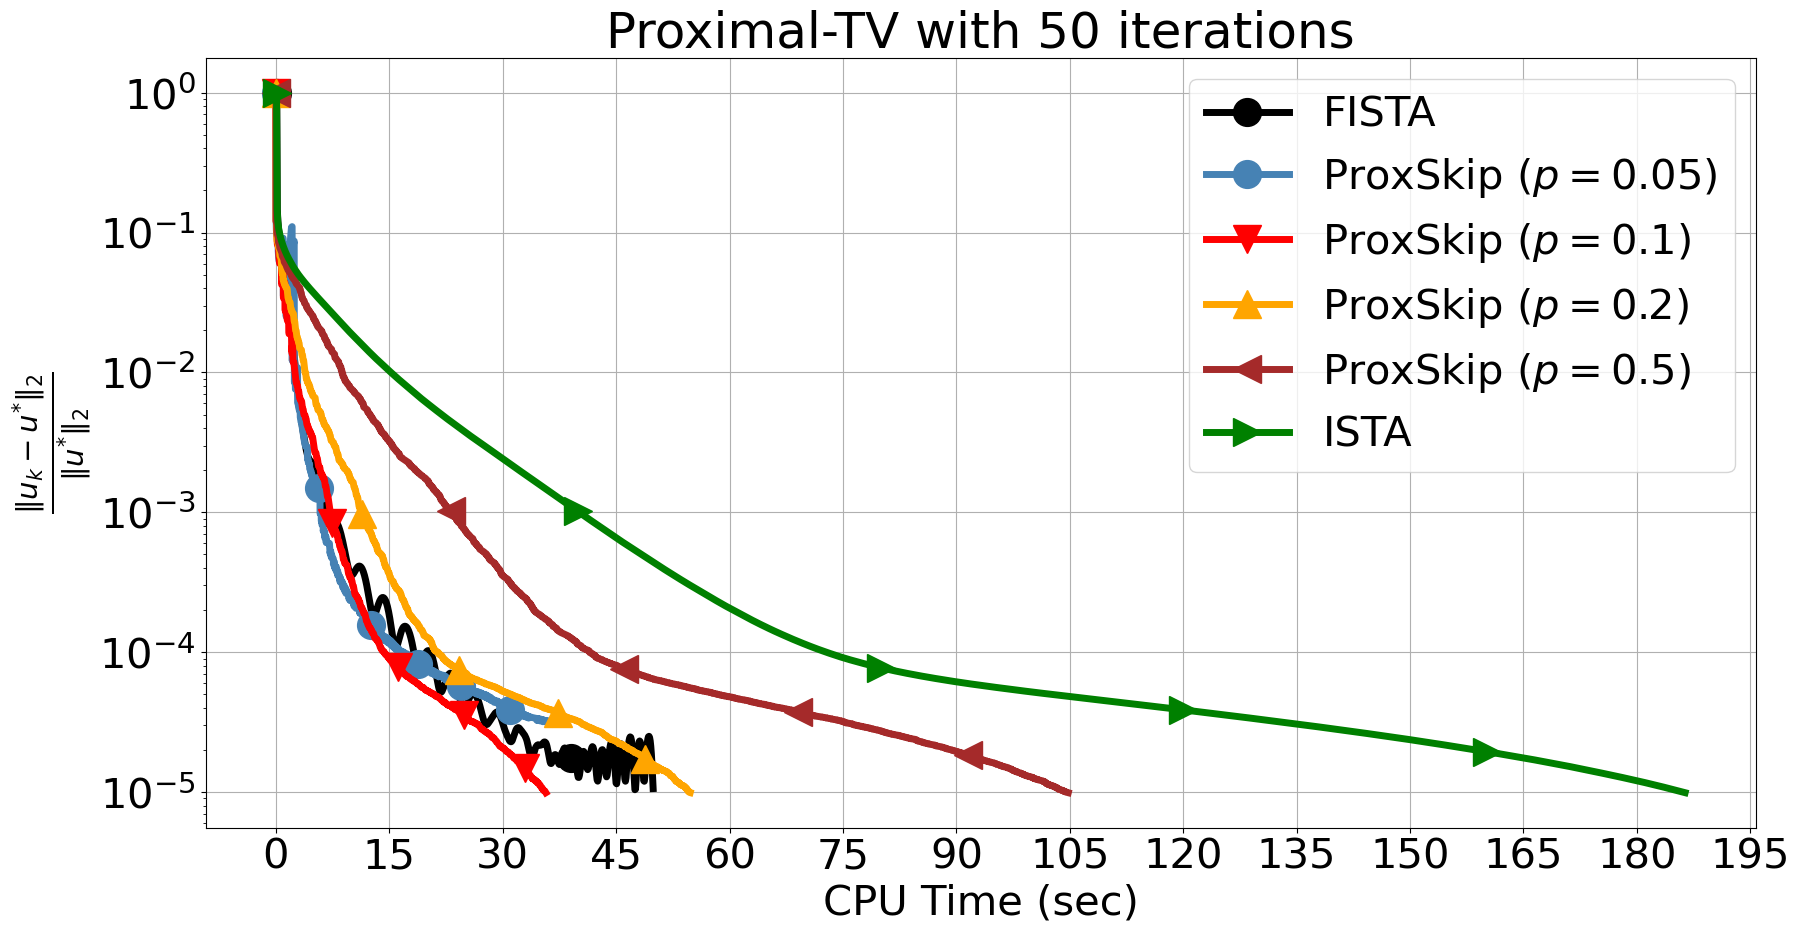

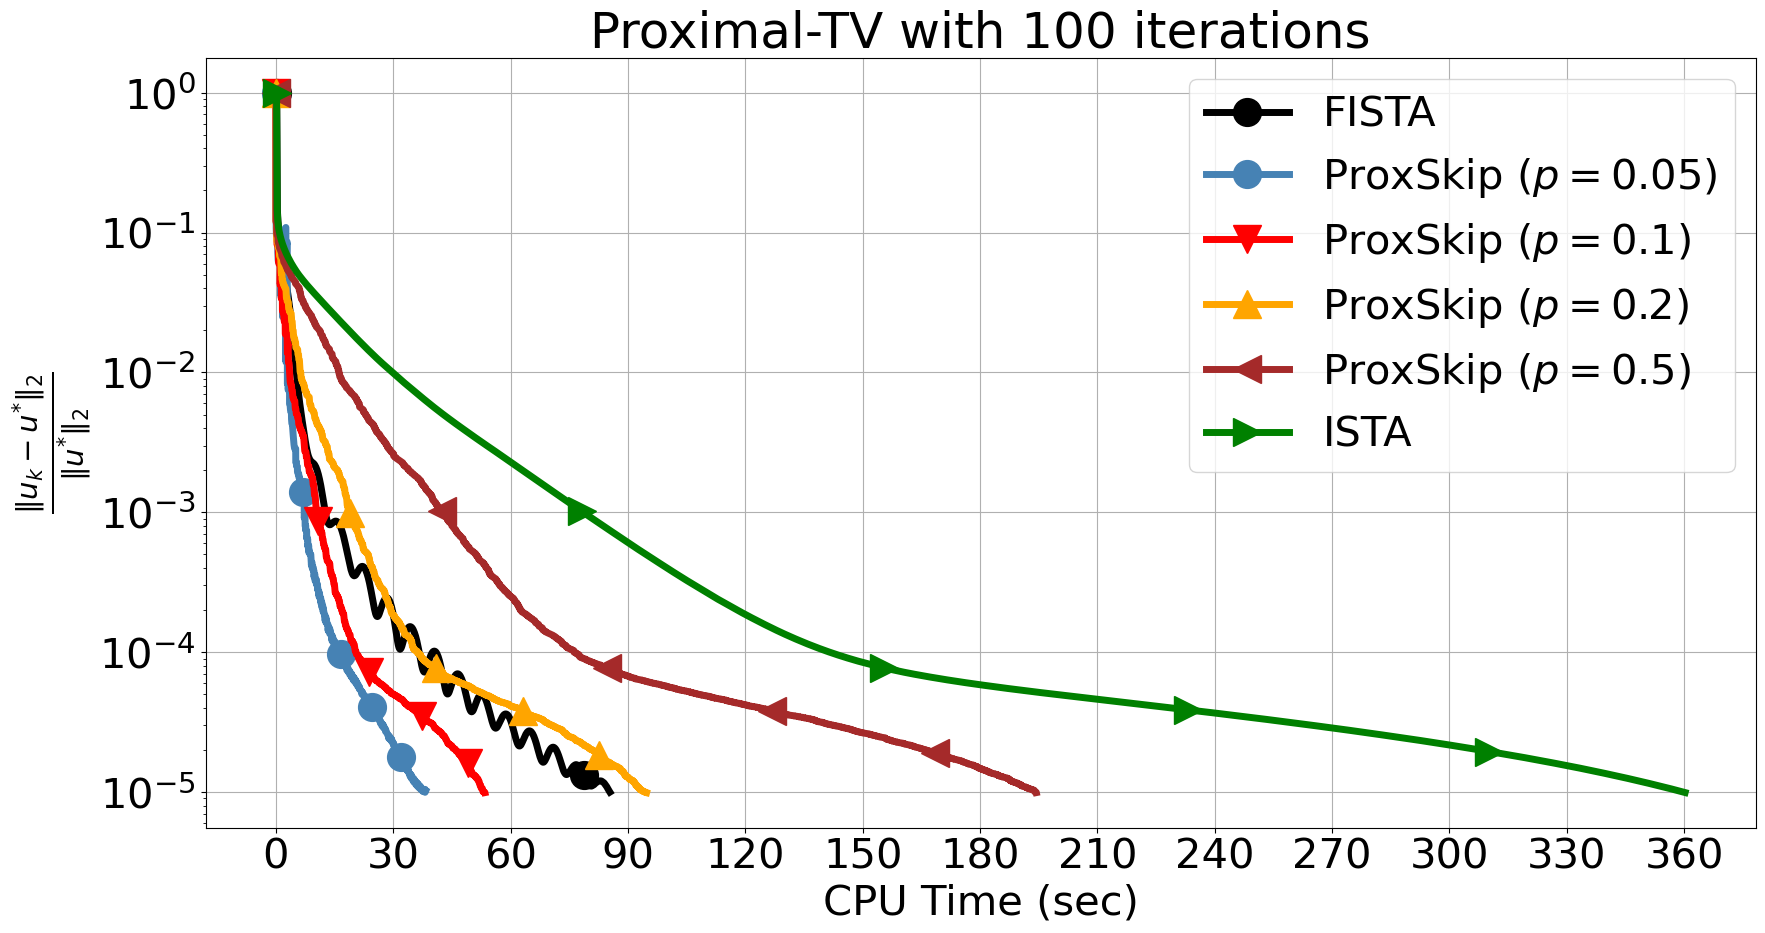

In [25]:
import matplotlib.ticker as ticker
markevery=500

for warm in warm_num:
    fig, ax = plt.subplots(figsize=(20,10))
    
    ax.semilogy(np.cumsum(fista_avg_time_per_iteration[warm]), fista_avg_rse_per_iteration[warm][:-1], label="FISTA", markevery=markevery, marker=markers[2], color="black")
    
    for i in range(len(probs)):
    
        if probs[i]==1.0:
            ax.semilogy(np.cumsum(proxskip_avg_time_per_iteration[warm][probs[i]]), 
                        proxskip_avg_rse_per_iteration[warm][probs[i]][:-1], label=r"ISTA",  
                        markevery=markevery, color=colors[i], marker = markers[i+2])
        else:
            ax.semilogy(np.cumsum(proxskip_avg_time_per_iteration[warm][probs[i]]), 
                        proxskip_avg_rse_per_iteration[warm][probs[i]][:-1], label=r"ProxSkip ($p={}$)".format(probs[i]),  
                        markevery=markevery, color=colors[i], marker = markers[i+2])
    
    # plt.xlim(50,58)
    ax.legend()
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=15))
    ax.grid(which="major")
    plt.ylabel(r"$\frac{\|u_{k} - u^{*}\|_{2}}{\|u^{*}\|_{2}}$")
    plt.xlabel('CPU Time (sec)')
    plt.title("Proximal-TV with {} iterations".format(warm))
    # plt.savefig("figures/deblurring/ista_fista_proxskip_{}warm_alpha_{}_iterates_xaxis_time_pdhg_precond.png".format(warm, alpha), bbox_inches='tight')
    plt.show()